# Data Preprocessing

## 데이터를 변환하는 함수
- 데이터를 학습에 사용할 수 있도록 데이터 변환
- Smiles(문자형) -> 분자지분(166 bits)


smiles2fing 함수는 SMILES 형식의 문자열 리스트를 입력받아, 각 분자에 대한 MACCS 키 기반의 분자 fingerprint를 생성하고 처리합니다.

smiles2fing 함수의 동작 과정은 아래와 같습니다.

smiles2fing 함수의 입력으로 받아온 SMILES 문자열 리스트(smiles)는 Chem.MolFromSmiles 함수를 통해 각 문자열에 해당하는 분자 객체로 반환됩니다.

Chem.MolFromSmiles에 의해 반환되지 못하는 문자열은, None으로 반환됩니다.
None으로 반환된 모든 문자열들의 인덱스를 새로운 리스트 'ms_none_idx'에 저장합니다.

ms_tmp에서 None이 아닌(분자 객체로 성공적으로 반환된 친구들) 분자 객체만을 필터링하여 새로운 리스트 'ms'에 저장합니다.

ms에 속하는 모든 객체를 각각 MACCSkeys.GenMACCSKeys 함수를 통해 MACCS키로 변환하고, 이를 새로운 리스트 'maccs'에 저장합니다.

maccs의 모든 각 원소를 이진 문자열로 변환하고, 이를 새로운 리스트 'maccs_bit'에 저장합니다.

maccs_bit를 pandas 데이터프레임으로 변환합니다.

pandas.DataFrame을 통해 생성된 데이터프레임은 'maccs'라는 하나의 열을 가집니다.
str.split 메서드를 사용해 이진 문자열을 개별 문자 단위로 분할합니다.

expand 옵션이 True이기 때문에 분할된 개별 문자가 데이터프레임의 별도 열로 확장됩니다.
단, 최대 167개의 문자로 분할될 수 있습니다.
이진 문자열을 분할하면 첫 번째 열은 항상 비어있는 값으로 채워집니다. 해당 열은 불필요하기 때문에 데이터프레임에서 제거합니다.

데이터프레임의 열의 이름을 maccs_1, maccs_2, maccs_3, ..., maccs_167로 지정합니다.

데이터프레임의 데이터 타입을 정수로 변환하고, 인덱스를 재설정합니다.

함수의 output으로 None으로 반환된 문자열들의 인덱스와 각종 처리가 수행된 fingerprint 데이터프레임을 반환합니다.

In [1]:
def smiles2fing(smiles):
    ms_tmp = [Chem.MolFromSmiles(i) for i in smiles]
    ms_none_idx = [i for i in range(len(ms_tmp)) if ms_tmp[i] == None]

    ms = list(filter(None, ms_tmp))

    maccs = [MACCSkeys.GenMACCSKeys(i) for i in ms]
    maccs_bit = [i.ToBitString() for i in maccs]

    fingerprints = pd.DataFrame({'maccs': maccs_bit})
    fingerprints = fingerprints['maccs'].str.split(pat = '', n = 167, expand = True)
    fingerprints.drop(fingerprints.columns[0], axis = 1, inplace = True)

    colname = ['maccs_' + str(i) for i in range(167)]
    fingerprints.columns = colname
    fingerprints = fingerprints.astype(int).reset_index(drop = True)

    return ms_none_idx, fingerprints

## Data Preprocessing

In [2]:
# 라이브러리 호출
import pandas as pd
import numpy as np

# rdkit: 화학 정보학과 기계 학습을 위한 오픈 소스 화학 정보학 소프트웨어 툴킷입니다.

try:
# rdkit.Chem: 분자와 관련된 기본적인 기능과 클래스를 제공합니다.
# rdkit.Chem.MACCSkys: 화합물의 분자 지문을 생성하는 데 사용되는 방법 중 하나입니다.
    from rdkit import Chem
    from rdkit.Chem import MACCSkeys

# rdkit 라이브러리가 호출되지 않을 시, 라이브러리 설치 후 재호출
except:
    import sys
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rdkit-pypi"])
    # subprocess.check_call([sys.executable, "-m", "conda", "install", "rdkit", "-c conda-forge"])

    from rdkit import Chem
    from rdkit.Chem import MACCSkeys

# 데이터를 불러오기 위한 경로 설정
folder = '.'
file = 'tox21.xlsm' # 12개의 label과 SMILE가 존재하는 데이터 파일
cur_sheet = 'Tox21'

# pandas 라이브러리를 통해 csv파일을 불러오기
data = pd.read_excel(f'{folder}/{file}', sheet_name= cur_sheet)
print()
print('='*100)
print('불러온 데이터파일(tox21.xlsm) 데이터 앞부분 확인')
print(data.head())  # 데이터 일부분을 출력
# 가공하고자 하는 데이터를 따로 추출
smiles = data['smiles'].to_numpy()
# smiles2fing 함수를 통해 데이터 변환 실시
_, fings = smiles2fing(smiles)  # fings 변수에 변환된 features가 저장되어 있음

# 학습에 사용할 수 있도록 데이터셋 생성
mol_id = data['mol_id']     # 이름
labels = data.iloc[:,0:12]  # label
dataset = pd.concat([mol_id, fings, labels], axis= 1)   # features

# 생성한 데이터셋을 csv파일로 내보내기
dataset.to_csv(f'{folder}/tox21_dataset.csv', index= False)

print()
print('='*100)
print('\n 생성한 dataset 앞부분')
dataset.head()


불러온 데이터파일(tox21.xlsm) 데이터 앞부분 확인
   NR-AR  NR-AR-LBD  NR-AhR  NR-Aromatase  NR-ER  NR-ER-LBD  NR-PPAR-gamma  \
0    0.0        0.0     1.0           NaN    NaN        0.0            0.0   
1    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
2    NaN        NaN     NaN           NaN    NaN        NaN            NaN   
3    0.0        0.0     0.0           0.0    0.0        0.0            0.0   
4    0.0        0.0     0.0           0.0    0.0        0.0            0.0   

   SR-ARE  SR-ATAD5  SR-HSE  SR-MMP  SR-p53    mol_id  \
0     1.0       0.0     0.0     0.0     0.0   TOX3021   
1     NaN       0.0     NaN     0.0     0.0   TOX3020   
2     0.0       NaN     0.0     NaN     NaN   TOX3024   
3     NaN       0.0     NaN     0.0     0.0   TOX3027   
4     0.0       0.0     0.0     0.0     0.0  TOX20800   

                                              smiles  
0                       CCOc1ccc2nc(S(N)(=O)=O)sc2c1  
1                          CCN1C(=O)NC(c2ccc

[11:31:49] WARNING: not removing hydrogen atom without neighbors




 생성한 dataset 앞부분


,mol_id,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,...,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,TOX3021,0,0,0,0,0,0,0,0,0,...,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,TOX3020,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,TOX3024,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,TOX3027,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,TOX20800,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data 불러오기

In [16]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# 데이터 파일 경로 설정
folder = '.'
file = 'tox21_dataset.csv'
path = f'{folder}/{file}'

# 데이터 파일 불러오기
df = pd.read_csv(path)

# 전체 데이터 수 파악
print('전체 데이터 갯수:', len(df.index))

# 데이터 앞부분 확인하기
df.head()

전체 데이터 갯수: 7831


,mol_id,maccs_0,maccs_1,maccs_2,maccs_3,maccs_4,maccs_5,maccs_6,maccs_7,maccs_8,...,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
0,TOX3021,0,0,0,0,0,0,0,0,0,...,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,TOX3020,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
2,TOX3024,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN
3,TOX3027,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0
4,TOX20800,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 전처리한 data EDA

## Label 분포 확인

NR-AR의 각 class별 갯수
  - 0인 데이터의 수: 6956
  - 1인 데이터의 수: 309
  - 결측값인 데이터의 수: 566



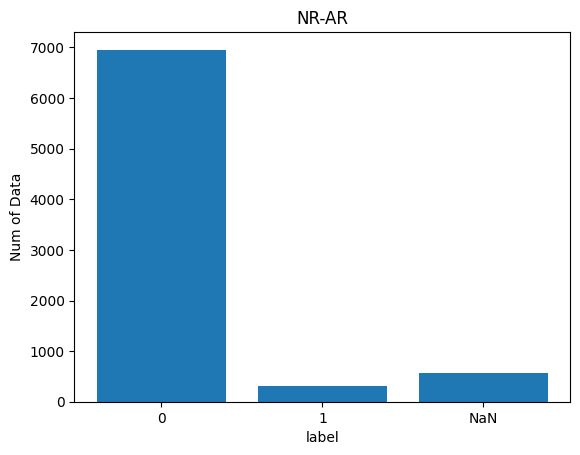

In [20]:
index_label = 'NR-AR'    # NR_AR label의 index

# 각 label에 해당하는 데이터의 수 구하기
    # loc:  인덱스(index)나 컬럼(column)의 이름을 기준으로 행과 열을 선택합니다.
    # iloc: 위치(인덱스나 컬럼의 숫자)를 기준으로 행과 열을 선택합니다.
label_0 = len(df.loc[df.loc[:,'NR-AR'] == 0])  # label이 0인 데이터
label_1 = len(df.loc[df.loc[:,'NR-AR'] == 1])  # label이 1인 데이터
label_nan = len(df[df.loc[:, index_label].isna()])  # label이 결측값인 데이터


print('NR-AR의 각 class별 갯수')
print('  - 0인 데이터의 수:',label_0)
print('  - 1인 데이터의 수:',label_1)
print('  - 결측값인 데이터의 수:',label_nan)
print()

# bar 그래프를 통해 data imbalance를 시각화
plt.bar([0,1,2], [label_0, label_1, label_nan])
plt.xticks([0,1,2], [0,1,'NaN'])
plt.title(f'{index_label}')
plt.xlabel('label')
plt.ylabel('Num of Data')
plt.show()

## feature 분포 확인

maccs_43의 분포
  - 0인 데이터의 수: 7284
  - 1인 데이터의 수: 547



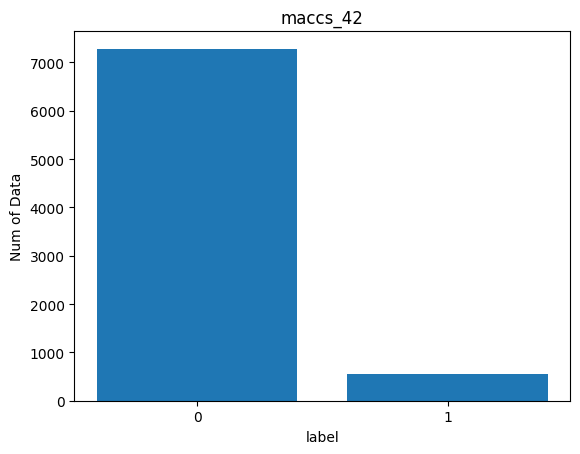

In [21]:
index_label = 43    # 2(maccs_1) ~ 167(maccs_166) 중 선택

# 각 label에 해당하는 데이터의 수 구하기
label_0 = len(df.loc[df.iloc[:,index_label] == 0])
label_1 = len(df.loc[df.iloc[:,index_label] == 1])

print(f'maccs_{index_label}의 분포')
print('  - 0인 데이터의 수:',label_0)
print('  - 1인 데이터의 수:',label_1)
print()

# bar 그래프를 통해 data imbalance를 시각화
plt.bar([0,1], [label_0, label_1])
plt.xticks([0,1], [0,1])
plt.title(f'{df.columns[index_label]}')
plt.xlabel('label')
plt.ylabel('Num of Data')
plt.show()

# Train/Test Split

In [22]:
# 데이터 분리를 하기 위한 하이퍼 파라미터 설정
label_idx = 0       # 학습에 사용하고 하는 label 선택 - 0 ~ 11중 선택 가능 | 0 -> NR-AR, 11 -> SR-p53
train_size = 0.8    # train과 test의 비율을 설정


feature = df.iloc[:,2:168]          # Features (166개)
label = df.iloc[:,168+label_idx]    # label

# label 기준으로 결측값(NaN)인 데이터 제거하기
idx_none = df[df.iloc[:,168 + label_idx].notna()].index # 결측값이 아닌 데이터의 index
feature = df.iloc[idx_none, 2:168]          # 필요한 데이터의 feature만 가져오기
label = df.iloc[idx_none, 168+label_idx]    # 필요한 데이터의 label만 가져오기


# 사이킷런에서 제공하는 함수를 이용하여 train과 test 데이터 분리하기
    # stratify : label을 기준으로 train과 test의 분포가 동일하도록 분리함
train_x, test_x, train_y, test_y = train_test_split(feature, label, train_size= train_size, stratify= label, random_state= 42)

print('='*100)
print('Oversampling전 데이터 shape 확인')
print('train dataset')
print(f'\tX : {train_x.shape}, Y : {train_y.shape}')
print('test dataset')
print(f'\tX : {test_x.shape}, Y : {test_y.shape}')


# Oversampling
    # SMOTE 방식을 통해 데이터 불균형 해결
    # SMOTE(Synthetic Minority Over-sampling Technique)는 불균형한 클래스 분포를 가진 데이터셋에서 소수 클래스를 오버샘플링하기 위한 기법으로, 소수 클래스의 샘플을 합성하여 데이터를 증가시키는 방법입니다.
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state= 42)
X_resampled, y_resampled = smote.fit_resample(train_x, train_y) # train 데이터를 늘려주기

train_x = X_resampled
train_y = y_resampled
# 분리한 결과 확인하기
print()
print('='*100)
print('Oversampling후 데이터 shape 확인')
print('train dataset')

# train 데이터 파일 생성하기
print(f'\tX : {train_x.shape}, Y : {train_y.shape}')
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)
dataset_train = pd.concat([train_x, train_y], axis= 1)
dataset_train.to_csv(f'{folder}/tox21_train.csv', index= False)

# test 데이터 파일 생성하기
print('test dataset')
print(f'\tX : {test_x.shape}, Y : {test_y.shape}')
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)
dataset_test = pd.concat([test_x, test_y], axis= 1)
dataset_test.to_csv(f'{folder}/tox21_test.csv', index= False)


Oversampling전 데이터 shape 확인
train dataset
	X : (5812, 166), Y : (5812,)
test dataset
	X : (1453, 166), Y : (1453,)

Oversampling후 데이터 shape 확인
train dataset
	X : (11130, 166), Y : (11130,)
test dataset
	X : (1453, 166), Y : (1453,)
